# Demand Forecast

The **goal** of this exercise is to create a demand forecast model for different products (or clusters of products).

The **evaluation** of the assignment will follow:

* Design process and thinking as a data analyst.
* Validation of knowledge on the different tools and steps throughout the process.
* Storytelling and visualisation of the insights.


Exercise **workflow**:

* Import dependencies & data (`../data/Historical\ Product\ Demand.csv`).
* Explore the dataset to assess its quality (nulls, skew, data types).
* Explore the dataset to obtain insights related to the production (e.g., unvariate / bivariate analysis).
* Explore the dataset as a time-series (min/max dates, seasonality, trends etc.).
* Implement / apply a forecast model:
    * Theory
    * Parameters tuning
    * Build/fit & Validation
    * Evaluate performance (e.g., forecast accuracy)
    
Notes:

Feel free to choose how to present the results throughout the exercise, what libraries (e.g., seaborn, bokeh, etc.) and tools (e.g., PowerBI or Tableau).
    

## Preamble

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from mlxtend.preprocessing import minmax_scaling
from sklearn.preprocessing import MinMaxScaler


# not mandatory, but might come handy
from scipy import stats
import statsmodels.api as sm

import random
random.seed(10)

## Data exploration

### Data quality assessment

* Explore the dataset to assess its quality (nulls, skew, data types)

### Production insights
* What products / categories are driving the demand?
* What warehouses are driving the production?

### Time-series insights
* Are there missing dates?
* Are all dates valid?
* What is the seasonability decomposition?


In [59]:
df = pd.read_csv("Historical Product Demand.csv")
print(" Data Sample : \n", df.head(3),"\n" )
print( " Data Shape : ", df.shape)

df_cpy = df.copy()

 Data Sample : 
    Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500  

 Data Shape :  (1048575, 5)


## **Data Quality Assessment** 

In [60]:
#Check the data types.
df_cpy.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

Change Order_Demand from Object to Numeric data type

In [61]:
## Change datatype of target variable to numeric
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand']

#Change the data type
#df_cpy['Order_Demand_abs'] = pd.to_numeric(df_cpy['Order_Demand'])

# while changing data type we saw there was an issue with value present in 112289 location
# let's check what it is
df_cpy['Order_Demand_abs'].iloc[112289]


'1 '

In [62]:
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace("(","")
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace(")","")
df_cpy['Order_Demand_abs'].iloc[112289]

'1 '

Let's change the datatype now

In [63]:
df_cpy['Order_Demand_abs'] = pd.to_numeric(df_cpy['Order_Demand_abs'])
df_cpy['Order_Demand_abs'].dtype

dtype('int64')

In [64]:

print( " Data type of Ordered demand :" , df_cpy.Order_Demand_abs.dtype)
print( " Data type of Date :" , df_cpy.Date.dtype)

 Data type of Ordered demand : int64
 Data type of Date : object


Change Date from object type to date

In [65]:
df_cpy['Date'] = pd.to_datetime(df_cpy['Date'])
df_cpy['Date']

0         2012-07-27
1         2012-01-19
2         2012-02-03
3         2012-02-09
4         2012-03-02
             ...    
1048570   2016-04-27
1048571   2016-04-27
1048572   2016-04-28
1048573   2016-10-07
1048574   2016-06-27
Name: Date, Length: 1048575, dtype: datetime64[ns]

In [66]:
df_cpy['Order_Demand_abs'].describe()

count    1.048575e+06
mean     4.906977e+03
std      2.892678e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand_abs, dtype: float64

In [67]:
df_cpy['Order_Demand_abs'].skew()

31.580569538175606

[Text(0.5, 0, 'Order Demand')]

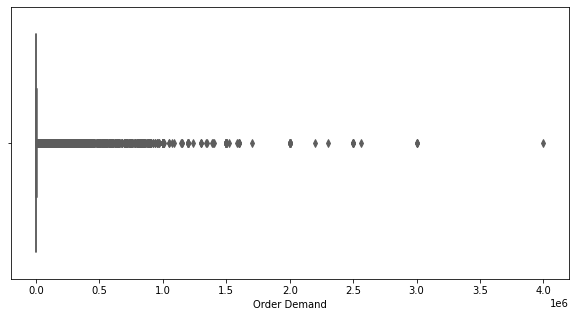

In [68]:
plt.figure(figsize = (10, 5))
sns.boxplot(df_cpy['Order_Demand_abs'],color='#42f5ce').set(xlabel='Order Demand')

Text(0.5, 1.0, 'Normalized data')

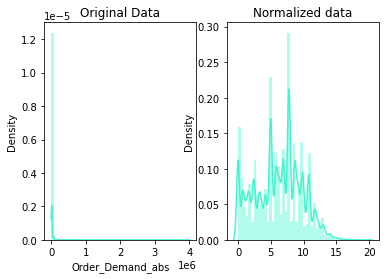

In [69]:
orders = df_cpy['Order_Demand_abs']

pos_orders = orders[orders > 0]

# Normalize the pledges using Box-Cox
normalized_orders = stats.boxcox(pos_orders)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(orders, ax=ax[0], color = "#42f5ce")
ax[0].set_title("Original Data")
sns.distplot(normalized_orders, ax=ax[1], color = "#42f5ce")
ax[1].set_title("Normalized data")

[Text(0.5, 0, 'Normalized Order Demand ')]

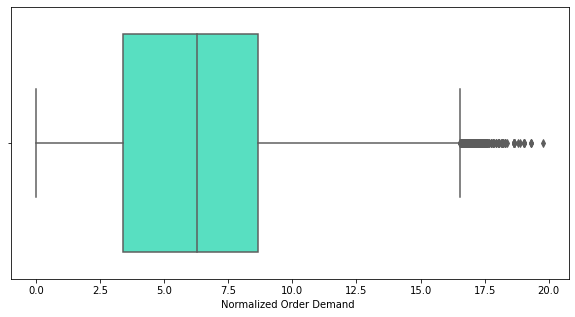

In [70]:
plt.figure(figsize = (10, 5))
sns.boxplot(normalized_orders,color='#42f5ce').set(xlabel='Normalized Order Demand ')

## **Production insights**  

In [71]:
df_cpy.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand',
       'Order_Demand_abs'],
      dtype='object')

##### **What warehouses are driving the production?**

##### Frequency of each warehouse

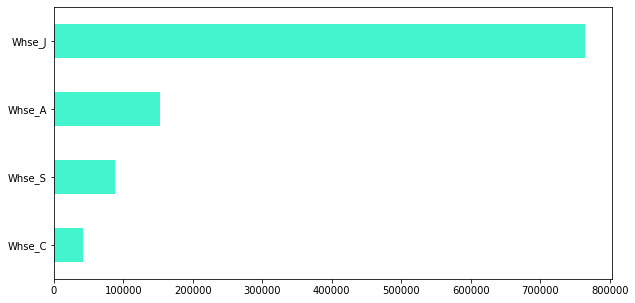

In [72]:
plt.figure(figsize = (10, 5))
df_cpy.Warehouse.value_counts().sort_values().plot(kind='barh',color = "#42f5ce")

##### Warehouse w.r.t Order Demands



In [73]:
# Amount of orders w.r.t Warehouses
warehouse_subset = df_cpy[["Warehouse","Order_Demand_abs"]]
warehouse_subset = warehouse_subset.groupby('Warehouse').sum().sort_values('Order_Demand_abs', ascending = False)

In [74]:
warehouse_trans = pd.DataFrame(warehouse_subset.reset_index())
Order_percent = round(warehouse_trans.Order_Demand_abs*100 /warehouse_trans.Order_Demand_abs.sum())

warehouse_order = pd.DataFrame({'Product Category':warehouse_trans.Warehouse,'Order demand (count)': warehouse_trans.Order_Demand_abs,'Order demand (%)': Order_percent})
warehouse_order.sort_values(by=['Order demand (%)'], ascending=False)
warehouse_order

,Product Category,Order demand (count),Order demand (%)
0,Whse_J,3363200396,65.0
1,Whse_S,1038024700,20.0
2,Whse_C,585071404,11.0
3,Whse_A,159036821,3.0


In [75]:
print( "Warehouse that contributes the most to Order demand is : ", warehouse_order.iloc[0,0] )
print( "Top Warehouse in order demand percentage : ", warehouse_order.iloc[0,2], "%" )

Warehouse that contributes the most to Order demand is :  Whse_J
Top Warehouse in order demand percentage :  65.0 %


##### **What products / categories are driving the demand?**



##### Frequency of each product category

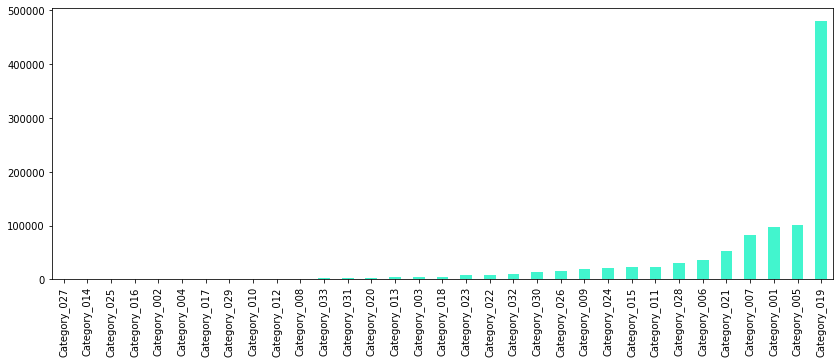

In [76]:
plt.figure(figsize = (14, 5))
df_cpy.Product_Category.value_counts().sort_values().plot(kind='bar',color = "#42f5ce")

##### Warehouse w.r.t Product Category

In [77]:
# Amount of orders w.r.t Product Category
prod_subset = df_cpy[["Product_Category","Order_Demand_abs"]]
prod_subset = prod_subset.groupby('Product_Category').sum().sort_values('Order_Demand_abs', ascending = False)
prod_trans = pd.DataFrame(prod_subset.reset_index())
Order_percent = round(prod_trans.Order_Demand_abs*100 /prod_trans.Order_Demand_abs.sum())
prod_order = pd.DataFrame({'Product Category':prod_trans.Product_Category,'Order demand (count)': prod_trans.Order_Demand_abs,'Order demand (%)': Order_percent})
prod_order.sort_values(by=['Order demand (%)'], ascending=False)
prod_order


,Product Category,Order demand (count),Order demand (%)
0,Category_019,4251207605,83.0
1,Category_006,405579330,8.0
2,Category_005,199681320,4.0
3,Category_007,128691531,3.0
4,Category_028,49150112,1.0
5,Category_033,42610000,1.0
6,Category_030,40966555,1.0
7,Category_021,4480660,0.0
8,Category_032,4473048,0.0
9,Category_009,3782141,0.0


In [78]:
print( "Category that contributes the most to Order demand is : ", prod_order.iloc[0,0] )
print( "Top category in order demand percentage : ", prod_order.iloc[0,2], "%" )

Category that contributes the most to Order demand is :  Category_019
Top category in order demand percentage :  83.0 %


## **Time-series insights**
*   Are there missing dates?
*   Are all dates valid?
*   What is the seasonability decomposition?








In [79]:
# Check missing values
print("Number of columns : ", len(df_cpy.columns))
print("Missing values by rows : " ,df_cpy.isnull().any(axis=1).sum())
print("Number of rows : " ,len(df_cpy), "\n")

# Number of missing values for each column
missing_percent = df_cpy.isnull().sum()*100 / len(df_cpy)
miss_df = pd.DataFrame({'missing (count)': df_cpy.isnull().sum(),'missing (%)': missing_percent})
miss_df.sort_values(by=['missing (%)'], ascending=False)



Number of columns :  6
Missing values by rows :  11239
Number of rows :  1048575 



,missing (count),missing (%)
Date,11239,1.071836
Product_Code,0,0.000000
Warehouse,0,0.000000
Product_Category,0,0.000000
Order_Demand,0,0.000000
Order_Demand_abs,0,0.000000


Only 1.07 % data is missing which belongs to date column, we can drop these rows

In [80]:
df_cpy.dropna(axis=0, inplace=True) #remove all rows with na's.
df_cpy.head()

# Number of missing values for each column
missing_percent = df_cpy.isnull().sum()*100 / len(df_cpy)
print(" Missing percentage by each column  :- \n", missing_percent)

 Missing percentage by each column  :- 
 Product_Code        0.0
Warehouse           0.0
Product_Category    0.0
Date                0.0
Order_Demand        0.0
Order_Demand_abs    0.0
dtype: float64


In [81]:
### Extract month, year, quarter , weekday and day from date
df_cpy['Day'] =  df_cpy['Date'].dt.day
df_cpy['Month'] =  df_cpy['Date'].dt.month
df_cpy['Month_name'] =  df_cpy['Date'].dt.strftime('%B')
df_cpy['Year'] =  df_cpy['Date'].dt.year
df_cpy["Quarter"] = df_cpy['Date'].dt.quarter
df_cpy["DayOfWeek"] = df_cpy["Date"].dt.weekday

### Adding order to month names
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df_cpy['Month_name'] = pd.Categorical(df_cpy['Month_name'], categories= months , ordered=True)

In [82]:
print(" Year range : ",df_cpy["Year"].min(), "-",df_cpy["Year"].max())

 Year range :  2011 - 2017


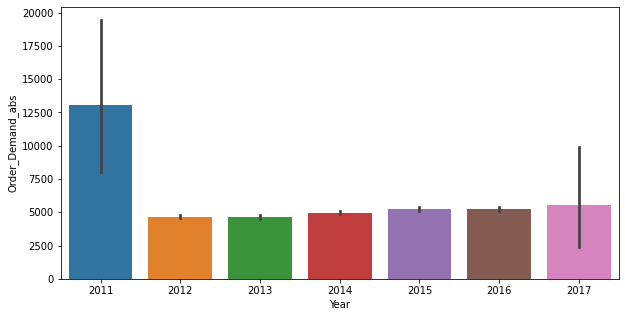

In [83]:
plt.figure(figsize = (10, 5))
sns.barplot(y=df_cpy['Order_Demand_abs'],x= df_cpy['Year'])

In [84]:
#Index the date
date_sub = df_cpy.set_index('Date')
#date_sub.index 
date_sub.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,Order_Demand_abs,Day,Month,Month_name,Year,Quarter,DayOfWeek
Date,,,,,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,100,27,7,July,2012,3,4
2012-01-19,Product_0979,Whse_J,Category_028,500,500,19,1,January,2012,1,3
2012-02-03,Product_0979,Whse_J,Category_028,500,500,3,2,February,2012,1,4
2012-02-09,Product_0979,Whse_J,Category_028,500,500,9,2,February,2012,1,3
2012-03-02,Product_0979,Whse_J,Category_028,500,500,2,3,March,2012,1,4


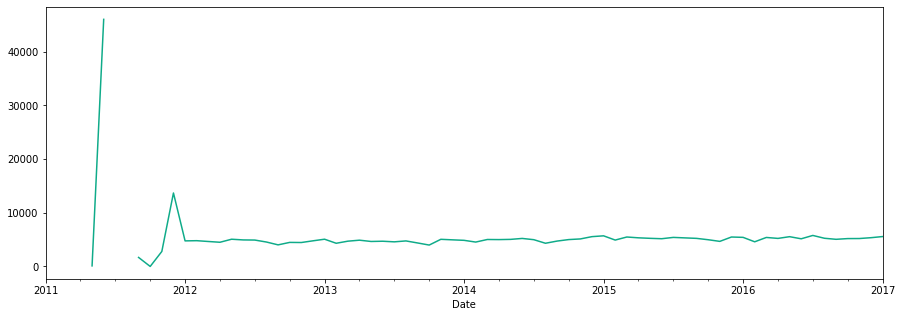

In [85]:
# Average demand orders
# resample('MS') = first day of the month

y = date_sub['Order_Demand_abs'].resample('MS').mean()
y.plot(figsize=(15,5), color = "#0fab89")
plt.show()

*   In 2011 : Avg. orders for the month of June are the maximum.
*   In 2011 : Avg. orders for the months February, March, April,july and august are zero and hence we don't see a line plotted for these months in the above graph ( Please refer table below for more clarity ).



#### Annual average order per month 

In [86]:
tbl = df_cpy.pivot_table(index='Year', columns=['Month_name'], values='Order_Demand_abs', aggfunc='mean')
tbl

Month_name,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2011,2.000000,NaN,NaN,NaN,108.000000,46000.000000,NaN,NaN,1682.000000,2.333333,2791.096774,13676.463211
2012,4760.537787,4797.869006,4647.560310,4503.559554,5069.122546,4938.896517,4914.299977,4547.855991,4018.979632,4477.001080,4456.745923,4771.958735
2013,5072.665044,4316.825808,4705.264126,4890.554312,4651.737153,4696.175751,4583.131098,4752.774310,4374.688905,3983.279638,5053.062201,4955.223244
2014,4862.820352,4539.828154,5019.437824,5000.381037,5040.974518,5216.523590,4983.481741,4319.314213,4724.780601,5003.498187,5122.536887,5550.122808
2015,5701.752480,4912.332855,5481.915961,5331.037323,5236.323722,5163.431108,5408.574424,5318.172116,5228.155740,4974.822097,4669.399596,5480.608467
2016,5416.990630,4591.757037,5398.906955,5222.581883,5542.872437,5150.018943,5773.218617,5248.273136,5053.258065,5188.114199,5199.225151,5353.679968
2017,5565.415094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


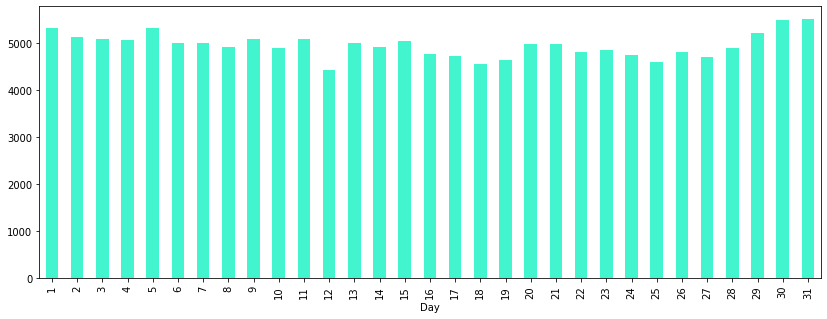

In [87]:
plt.figure(figsize = (14, 5))
date_sub.groupby('Day')['Order_Demand_abs'].mean().plot.bar(color= "#42f5ce")

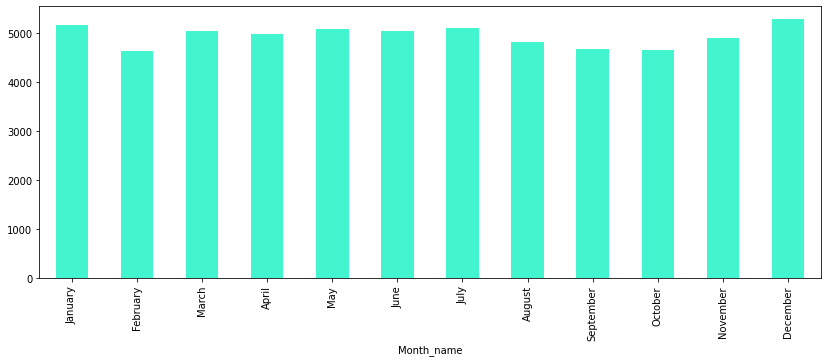

In [88]:
plt.figure(figsize = (14, 5))

# plot
date_sub.groupby("Month_name")['Order_Demand_abs'].mean().plot.bar(color="#42f5ce")

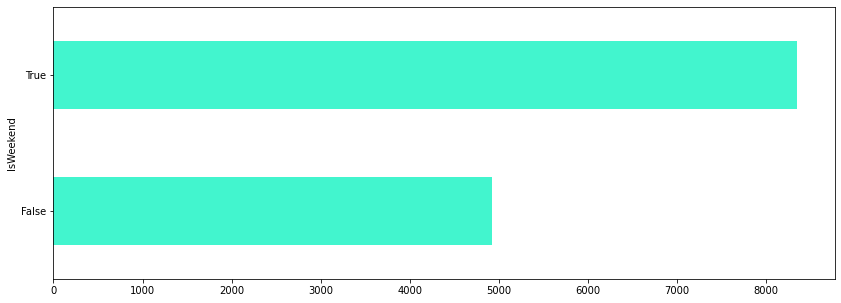

In [89]:
date_sub["IsWeekend"] = date_sub["DayOfWeek"] >= 5
plt.figure(figsize = (14, 5))
date_sub.groupby("IsWeekend")['Order_Demand_abs'].mean().plot.barh(color = "#42f5ce")

Most orders are demanded during **Weekend**

#### Dicky fuller test to evaluate staionarity


*   Null Hypothesis (H0): If failed to be rejected, it suggests the time series is non-stationary. It has some time dependent structure.
*   Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series is stationary. It does not have time-dependent structure.

*We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).*

*   p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
*   p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.


In [100]:
from statsmodels.tsa.stattools import adfuller
y = y.ffill().bfill()
X = y.values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.328614
p-value: 0.000396
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


Dicky fuller test prints the test statistic value of -4.37. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset) and p-value is also less than 0.05 hence we can say that the data is stationary

#### Seasonability decomposition

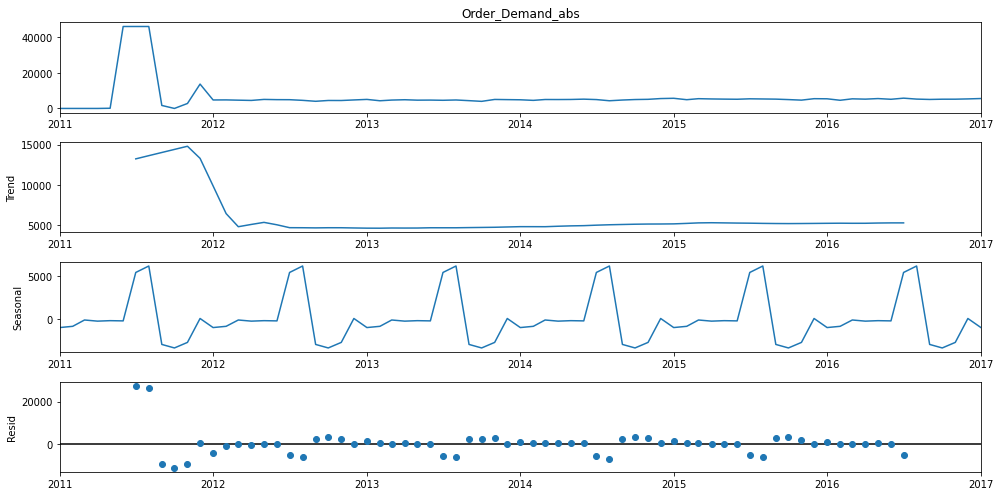

In [99]:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 14, 7
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Forecast model

### Theory
* Describe the basic theory behind the solution you have decided to apply

### Implementation
* What parameters have you consider to tune and why are those important for best-fit?

#### SARIMA

An ARIMA model is characterized by 3 terms: p, d, q where,

* p is the order of the AR term
* q is the order of the MA term
* d is the number of differences required to make the time series stationary
* When dealing with seasonal data, we should use SARIMA ( Seasonal ARIMA) as 's'. ARIMA(p,d,q)(P,D,Q)s.

In [92]:
# We use the  Gride search identify the optimal parameters for our model

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
      results = mod.fit()
      print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1540.742623111692
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1181.7578391219208
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1270.0726811050538
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:718.0215219482488
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1191.484231482625
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1180.317752668866
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:729.8499200684857
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:716.2747936745272
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1489.3943535783512
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1226.4020735800334
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1231.6680886145596
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:697.5126828699803
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1148.9307876679602
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1195.386195902275
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:731.8389721292572
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:702.4283016084395
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1475.5798234831407
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:875

AIC value 697.5 is least with order (0, 0, 1) and Seasonal order (0, 1, 1, 12) 

##### Fit the model

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2692      0.094      2.873      0.004       0.086       0.453
ma.S.L12       0.0014      0.010      0.139      0.889      -0.018       0.021
sigma2      1.437e+05    3.4e+04      4.223      0.000     7.7e+04     2.1e+05


### Model diagnostics 

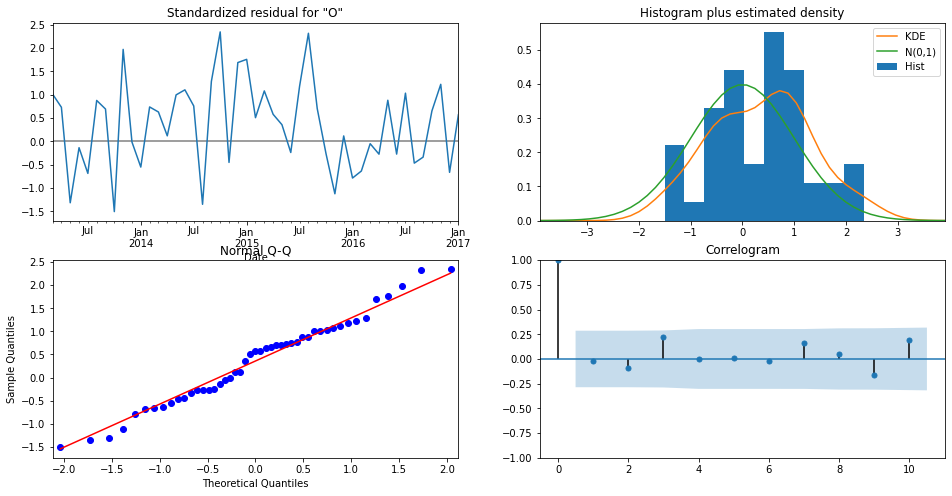

In [94]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our model diagnostics suggests that the model residuals are near normally distributed.


##### Validate model

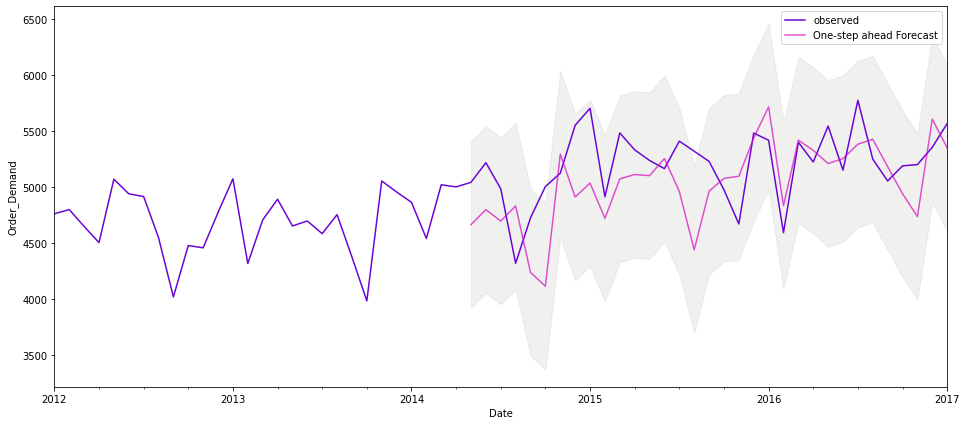

In [95]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2012':].plot(label='observed',color = "#6a04d6")
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 7),color = "#d609c2")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#b5b5b3', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#### Forecast Accuracy

In [96]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 66785.07


In [97]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 258.43


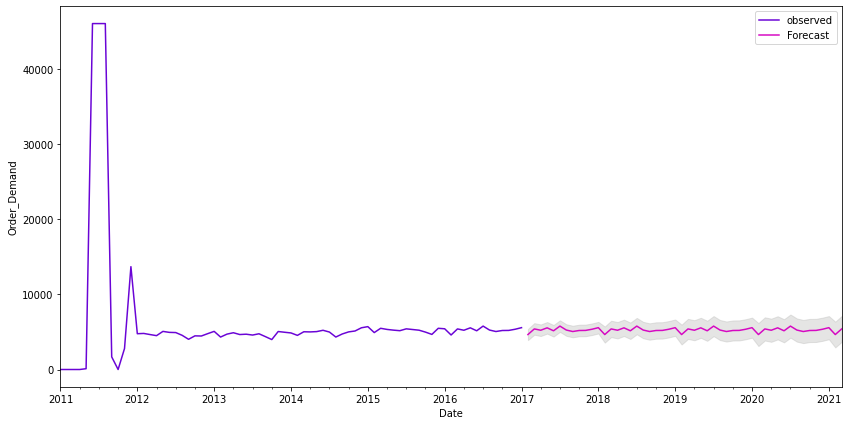

In [98]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7),color = "#6a04d6")
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',color = "#d609c2")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#b5b5b3', alpha=.35)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()